In [45]:
# import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
# import os
# import pandas as pd
from analysis_functions import *
import matplotlib.patches as mpatches

In [46]:
from analysis_functions import *

In [3]:
# image = r'C:\Users\Willi\Desktop\134L Images\good_fits\van_Maanen_g.fits'
image = r'C:\Users\admin1\OneDrive\Desktop\134L Images\good_fits\van_Maanen_g.fits'
hdul = fits.open(image)
image = hdul[1].data

# if not os.path.isfile(image):
#     print('File not found')

Calculate temperature using color index data

Try with just the imported functions.

In [3]:
file_root = r'C:\Users\Willi\Desktop\134L Images\good_fits'
# file_root = r'C:\Users\admin1\OneDrive\Desktop\134L Images\good_fits'

Final evaluations

In [4]:
data = calculate_all(file_root, 'omi02EriB_', 1208, 1225, 8, 5) # good
apparent_mag1 = data[1]
absolute_mag1 = data[2]
luminosity1 = data[3]
temp1 = data[4]
print(apparent_mag1, absolute_mag1, luminosity1, temp1)

[58523.33593749999, 27692.58515625, 8040.0154296875]
[ 9.78007223 10.00158909 10.16225079] [11.2852222  11.50673907 11.66740077] [1.00674713e+24 8.20944225e+23 7.08025616e+23] [17000. 22200. 18500.]


In [5]:
data = calculate_all(file_root, 'WD0621-376_', 1166, 1259, 8, 76.7) # mag is good, temp is bad
apparent_mag2 = data[1]
absolute_mag2 = data[2]
luminosity2 = data[3]
temp2 = data[4]
print(apparent_mag2, absolute_mag2, luminosity2, temp2)
# temp should be around 66000, mag 12.1

[5950.871171875, 2245.7225, 545.4123486328124]
[12.21520916 12.70695636 13.06846054] [7.79123234 8.28297954 8.64448372] [2.51487465e+25 1.59888586e+25 1.14608227e+25] [100000. 100000. 100000.]


In [6]:
data = calculate_all(file_root, 'LHS_253_', 1251, 1175, 8, 8.52) # good
apparent_mag3 = data[1]
absolute_mag3 = data[2]
luminosity3 = data[3]
temp3 = data[4]
print(apparent_mag3, absolute_mag3, luminosity3, temp3)

[5136.876855468749, 3122.5885742187497, 928.5076171874999]
[12.2877662  12.26923754 12.35831156] [12.63556823 12.61703957 12.70611359] [2.90256523e+23 2.95252412e+23 2.71996831e+23] [10500. 14900. 11700.]


In [7]:
data = calculate_all(file_root, 'LAWD_8_', 1208, 1216, 8, 16.76) # good
apparent_mag4 = data[1]
absolute_mag4 = data[2]
luminosity4 = data[3]
temp4 = data[4]
print(apparent_mag4, absolute_mag4, luminosity4, temp4)

[944.6901406249999, 551.456390625, 167.00490624999998]
[14.18279463 14.231414   14.37469643] [13.06142455 13.11004393 13.25332636] [1.96082781e+23 1.87495871e+23 1.64315577e+23] [11700. 19700. 13500.]


In [8]:
data = calculate_all(file_root, 'van_Maanen_', 1189, 1173, 8, 4.3) # good
apparent_mag5 = data[1]
absolute_mag5 = data[2]
luminosity5 = data[3]
temp5 = data[4]
print(apparent_mag5, absolute_mag5, luminosity5, temp5)

[2985.94625, 2157.8111132812496, 894.7300195312498]
[12.96293269 12.69025376 12.65932917] [14.79559041 14.52291148 14.49198689] [3.96984103e+22 5.10322467e+22 5.25066756e+22] [7600. 9900. 8300.]


In [9]:
data = calculate_all(file_root, 'LAWD_74_', 1132, 1160, 8, 10.5) # good
apparent_mag6 = data[1]
absolute_mag6 = data[2]
luminosity6 = data[3]
temp6 = data[4]
print(apparent_mag6, absolute_mag6, luminosity6, temp6)
# should be around 12, 10000

[3025.3350585937496, 1780.7044677734375, 515.1843627929687]
[12.6776274  12.79920104 12.99777499] [12.5716809  12.69325455 12.89182849] [3.07848414e+23 2.75237409e+23 2.29233394e+23] [13400. 31000. 16500.]


In [10]:
data = calculate_all(file_root, 'WD0005+511_', 1220, 1190, 8, 415) # good
apparent_mag7 = data[1]
absolute_mag7 = data[2]
luminosity7 = data[3]
temp7 = data[4]
print(apparent_mag7, absolute_mag7, luminosity7, temp7)

[1889.9341015625, 682.31884765625, 174.057939453125]
[13.4311866  13.90627089 14.28815706] [5.34094611 5.8160304  6.19791658] [2.40231988e+26 1.55094758e+26 1.09104496e+26] [ 80900. 100000. 100000.]


In [11]:
data = calculate_all(file_root, 'WD0501-289_', 1195, 1242, 8, 138) # good
apparent_mag8 = data[1]
absolute_mag8 = data[2]
luminosity8 = data[3]
temp8 = data[4]
print(apparent_mag8, absolute_mag8, luminosity8, temp8)

[1216.9080729166667, 440.4211783854167, 118.69369303385416]
[14.00380044 14.51867462 14.9228158 ] [8.30440501 8.81927919 9.22342037] [1.56764340e+25 9.75657986e+24 6.72420792e+24] [100000. 100000. 100000.]


In [12]:
data = calculate_all(file_root, 'GJ283A_', 1195, 1197, 8, 9.15) # good. should be 13, 7500
apparent_mag9 = data[1]
absolute_mag9 = data[2]
luminosity9 = data[3]
temp9 = data[4]
print(apparent_mag9, absolute_mag9, luminosity9, temp9)
# original coords: 1225, 1225, doesn't look right

[1862.3566840277776, 1105.9457682291666, 424.9616753472222]
[13.48435603 13.41822226 13.46107031] [13.67725056 13.61111679 13.65396484] [1.11201093e+23 1.18185056e+23 1.13611775e+23] [ 9800. 12400. 10500.]


In [13]:
data = calculate_all(file_root, 'GJ1015B_', 1217, 1190, 8, 22.9) # good
apparent_mag10 = data[1]
absolute_mag10 = data[2]
luminosity10 = data[3]
temp10 = data[4]
print(apparent_mag10, absolute_mag10, luminosity10, temp10)

[802.382998046875, 402.79695312499996, 121.37268554687498]
[14.39658235 14.49952017 14.69415733] [12.59740494 12.70034276 12.89497991] [3.00640375e+23 2.73446378e+23 2.28568993e+23] [12900. 29700. 15900.]


In [14]:
data = calculate_all(file_root, 'GJ440_', 1128, 1237, 8, 4.64) # good. should be 11.5, 8000
apparent_mag11 = data[1]
absolute_mag11 = data[2]
luminosity11 = data[3]
temp11 = data[4]
print(apparent_mag11, absolute_mag11, luminosity11, temp11)
# original coords: 1180, 1187, doesn't look right

[7837.92802734375, 5098.732324218749, 1555.0488037109374]
[11.93851155 11.81595994 11.94363828] [13.60592164 13.48337004 13.61104838] [1.18751915e+23 1.32941711e+23 1.18192503e+23] [ 9100. 18000. 10900.]


In [15]:
data = calculate_all(file_root, 'WD0615-59_', 1133, 1256, 8, 36.06) # good
apparent_mag12 = data[1]
absolute_mag12 = data[2]
luminosity12 = data[3]
temp12 = data[4]
print(apparent_mag12, absolute_mag12, luminosity12, temp12)

[901.24890625, 404.9202864583333, 104.97459309895834]
[14.28232563 14.59353102 14.89489544] [11.49719702 11.80840241 12.10976683] [8.28190933e+23 6.21796563e+23 4.71088551e+23] [ 22900. 100000.  36400.]


Now plot the data.

In [16]:
solar_luminosity = 3.846e26

In [54]:
star_names = ['omi 02 Eri B', 'WD 0621-376', 'LHS 253', 'LAWD 8', 'van Maanen', 'LAWD 74', 'WD 0005+511', 'WD 0501-289', 'GJ 283 A', 'GJ 1015 B', 'GJ 440', 'WD1615-59']
star_types = ['DA', 'DA', 'DA', 'DQ', 'DA', 'DB', 'DO', 'DO', 'DZ', 'DQ', 'DQ', 'DB']
temperature_errors = [104, 18566, 474, 3714, 205, 5091, 813, 6041, 42, 188, 219, 268]
# luminosity_error_g = [2.79e-6, 1.39e-3, 9.44e-6, 4.15e-5, 1.05e-6, 7.95e-5, 0.000714, 0.00025, 3.36e-7, 2.21e-6, 9.15e-6, 3.22e-6]
# luminosity_error_r = [1.3e-5, 7.71e-3, 3.34e-5, 0.00015, 3.33e-6, 0.00025, 0.00405, 0.00153, 1.3e-6, 1.02e-5, 4.98e-9, 1.54e-5]
# luminosity_error_i = [1.33e-10, 9.41e-6, 3.48e-6, 1.43e-5, 4.51e-7, 2.62e-7, 0.000437, 0.000144, 8.52e-6, 9.51e-7, 4.9e-6, 1.73e-6]

luminosity_error_g = [0.00028, 0.13, 0.0009, 4.15e-5, 0.00011, 0.7, 0.071, 0.025, 3.4e-5, 0.00022, 0.00092, 0.00032]
luminosity_error_r = [0.00013, 0.57, 0.0033, 0.00015, 0.00033, 0.025, 0.09, 0.15, 0.00013, 0.001, 0.005, 0.0015]
luminosity_error_i = [0.000133, 0.6, 0.00034, 0.0014, 4.5e-5, 0.0026, 0.05, 0.0144, 0.00085, 0.0095, 0.00049, 1.73e-6]
# Define color mapping for star types
color_map = {
    'DA': 'red',
    'DC': 'black',
    'DO': 'blue',
    'DZ': 'green',
    'DQ': 'grey',
    'DB': 'purple'  # Assuming 'DB' is purple, you can change it as needed
}

In [17]:
literature_apparent_mags_V = [9.52, 12.09, 11.86, 13.84, 12.38, 12.31, 13.32, 13.58, 13.06, 14.08, 11.5, 14.09]
literature_temperatures = [16265, 66060, 9086, 9278, 6455, 10805, 100000000, 73751, 7650, 10487, 8062, 15349]
literature_distances = [5.0077, 76.69, 8.52, 16.7615, 4.32, 10.51, 415, 138.25, 9.15, 22.9, 4.64, 36.06]

In [18]:
literature_absolute_mags = []
for i in range(len(literature_apparent_mags_V)):
    literature_absolute_mags.append(literature_apparent_mags_V[i] - 5 * (np.log10(literature_distances[i]) - 1))

literature_luminosities = []
for i in range(len(literature_apparent_mags_V)):
    literature_luminosities.append(calculate_luminosity(literature_absolute_mags[i]))

print(literature_luminosities)

[1.2831749910348513e+24, 2.821543533948672e+25, 4.3041606174495096e+23, 2.689273935485155e+23, 6.85451566893113e+22, 4.327277155205123e+23, 2.6613713254447173e+26, 2.324553574181905e+25, 1.643809431932556e+23, 4.0242063737400224e+23, 1.778464665330836e+23, 9.88691327503762e+23]


In [51]:
# temperatures = []
# luminosities = []
# star_names = ['omi 02 Eri B', 'WD 0621-376', 'LHS 253', 'LAWD 8', 'van Maanen', 'LAWD 74', 'WD 0005+511', 'WD 0501-289', 'GJ 283 A', 'GJ 1015 B', 'GJ 440', 'WD1615-59']

# for i in range(1, 13):
#     temp = globals()[f'temp{i}']
#     luminosity = globals()[f'luminosity{i}']
#     temperatures.append(temp[0])
#     luminosities.append(luminosity[0]) # g band

# plt.figure(figsize=(10, 6))

# for i, name in enumerate(star_names):
#     plt.scatter(temperatures[i], luminosities[i], label=name)

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Temperature (K)', fontweight='bold', fontsize=14)
# plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
# plt.title('Temperature vs Luminosity for g Band', fontsize=16, fontweight='bold')
# plt.legend(fontsize=10)
# plt.grid(True)
# plt.show()

In [50]:
# temperatures = []
# luminosities = []
# star_names = ['omi 02 Eri B', 'WD 0621-376', 'LHS 253', 'LAWD 8', 'van Maanen', 'LAWD 74', 'WD 0005+511', 'WD 0501-289', 'GJ 283 A', 'GJ 1015 B', 'GJ 440', 'WD1615-59']
# star_types = ['DA', 'DA', 'DA', 'DQ', 'DA', 'DB', 'DO', 'DO', 'DZ', 'DQ', 'DQ', 'DB']

# for i in range(1, 13):
#     temp = globals()[f'temp{i}']
#     luminosity = globals()[f'luminosity{i}']
#     temperatures.append(temp[0])
#     luminosities.append(luminosity[0]/solar_luminosity) # g band, normalize by solar luminosity

# # Normalize temperatures for colormap
# norm = plt.Normalize(min(temperatures), max(temperatures))
# cmap = plt.get_cmap('coolwarm')

# plt.figure(figsize=(9, 6))

# for i, name in enumerate(star_names):
#     plt.scatter(temperatures[i], luminosities[i], color=cmap(norm(temperatures[i])), label=f'{i+1}: {name}')
#     plt.annotate(i+1, (temperatures[i], luminosities[i]), textcoords="offset points", xytext=(0,10), ha='center')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Temperature (K)', fontweight='bold', fontsize=14)
# plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
# plt.title('Temperature vs Luminosity for g Band', fontsize=16, fontweight='bold')
# plt.tick_params(axis='both', which='major', labelsize=12)
# plt.legend(fontsize=10)
# plt.show()

In [49]:
# temperatures = []
# luminosities = []
# star_names = ['omi 02 Eri B', 'WD 0621-376', 'LHS 253', 'LAWD 8', 'van Maanen', 'LAWD 74', 'WD 0005+511', 'WD 0501-289', 'GJ 283 A', 'GJ 1015 B', 'GJ 440', 'WD1615-59']
# star_types = ['DA', 'DA', 'DA', 'DQ', 'DA', 'DB', 'DO', 'DO', 'DZ', 'DQ', 'DQ', 'DB']

# # Define color mapping for star types
# color_map = {
#     'DA': 'red',
#     'DC': 'black',
#     'DO': 'blue',
#     'DZ': 'green',
#     'DQ': 'grey',
#     'DB': 'purple'
# }

# for i in range(1, 13):
#     temp = globals()[f'temp{i}']
#     luminosity = globals()[f'luminosity{i}']
#     temperatures.append(temp[0])
#     luminosities.append(luminosity[0]/solar_luminosity) # g band, normalize by solar luminosity

# plt.figure(figsize=(9, 6))

# for i, name in enumerate(star_names):
#     plt.scatter(temperatures[i], luminosities[i], color=color_map[star_types[i]], label=f'{i+1}: {name}')
#     plt.annotate(i+1, (temperatures[i], luminosities[i]), textcoords="offset points", xytext=(0,10), ha='center')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Temperature (K)', fontweight='bold', fontsize=14)
# plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
# plt.title('Temperature vs Luminosity for g Band', fontsize=16, fontweight='bold')
# plt.tick_params(axis='both', which='major', labelsize=12)
# plt.legend(fontsize=10)
# plt.show()

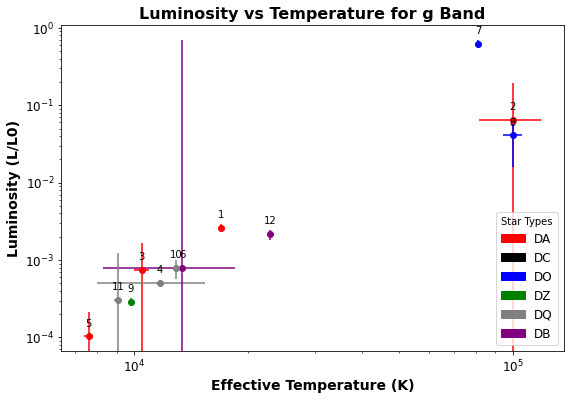

In [55]:
temperatures = []
luminosities = []

for i in range(1, 13):
    temp = globals()[f'temp{i}']
    luminosity = globals()[f'luminosity{i}']
    temperatures.append(temp[0])
    luminosities.append(luminosity[0]/solar_luminosity) # g band, normalize by solar luminosity

plt.figure(figsize=(9, 6))

for i, name in enumerate(star_names):
    plt.errorbar(temperatures[i], luminosities[i], xerr=temperature_errors[i], yerr=luminosity_error_g[i], fmt='o', color=color_map[star_types[i]], label=f'{i+1}: {name}')
    plt.annotate(i+1, (temperatures[i], luminosities[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=star_type) for star_type, color in color_map.items()]
plt.legend(handles=legend_handles, title="Star Types", fontsize=12, loc='lower right')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Effective Temperature (K)', fontweight='bold', fontsize=14)
plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
plt.title('Luminosity vs Temperature for g Band', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('Images/White_Dwarf_Luminosity_vs_Temp_g_Error.png')
plt.show()

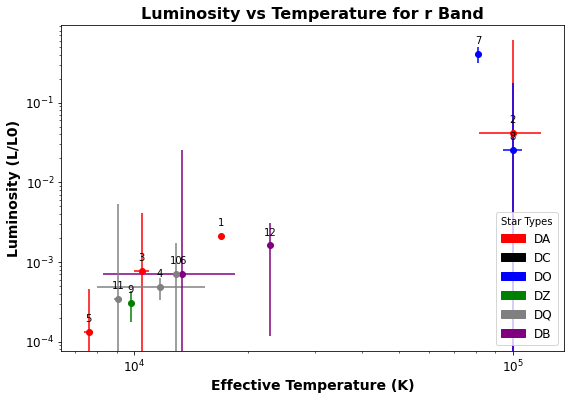

In [56]:
temperatures = []
luminosities = []

for i in range(1, 13):
    temp = globals()[f'temp{i}']
    luminosity = globals()[f'luminosity{i}']
    temperatures.append(temp[0])
    luminosities.append(luminosity[1]/solar_luminosity) # r band, normalize by solar luminosity

plt.figure(figsize=(9, 6))

for i, name in enumerate(star_names):
    plt.errorbar(temperatures[i], luminosities[i], xerr=temperature_errors[i], yerr=luminosity_error_r[i], fmt='o', color=color_map[star_types[i]], label=f'{i+1}: {name}')
    plt.annotate(i+1, (temperatures[i], luminosities[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=star_type) for star_type, color in color_map.items()]
plt.legend(handles=legend_handles, title="Star Types", fontsize=12, loc='lower right')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Effective Temperature (K)', fontweight='bold', fontsize=14)
plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
plt.title('Luminosity vs Temperature for r Band', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('Images/White_Dwarf_Luminosity_vs_Temp_r_Error.png')
plt.show()

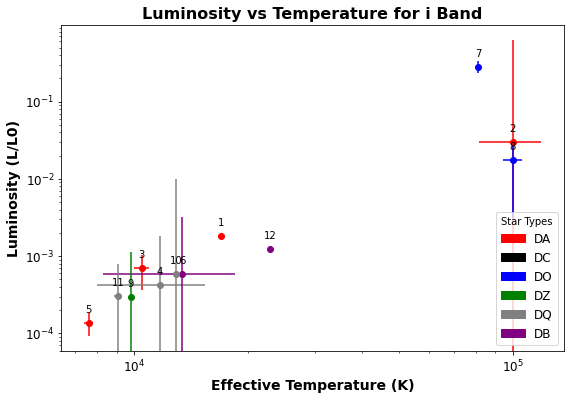

In [57]:
temperatures = []
luminosities = []

for i in range(1, 13):
    temp = globals()[f'temp{i}']
    luminosity = globals()[f'luminosity{i}']
    temperatures.append(temp[0])
    luminosities.append(luminosity[2]/solar_luminosity) # i band, normalize by solar luminosity

plt.figure(figsize=(9, 6))

for i, name in enumerate(star_names):
    plt.errorbar(temperatures[i], luminosities[i], xerr=temperature_errors[i], yerr=luminosity_error_i[i], fmt='o', color=color_map[star_types[i]], label=f'{i+1}: {name}')
    plt.annotate(i+1, (temperatures[i], luminosities[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=star_type) for star_type, color in color_map.items()]
plt.legend(handles=legend_handles, title="Star Types", fontsize=12, loc='lower right')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Effective Temperature (K)', fontweight='bold', fontsize=14)
plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
plt.title('Luminosity vs Temperature for i Band', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('Images/White_Dwarf_Luminosity_vs_Temp_i_Error.png')
plt.show()

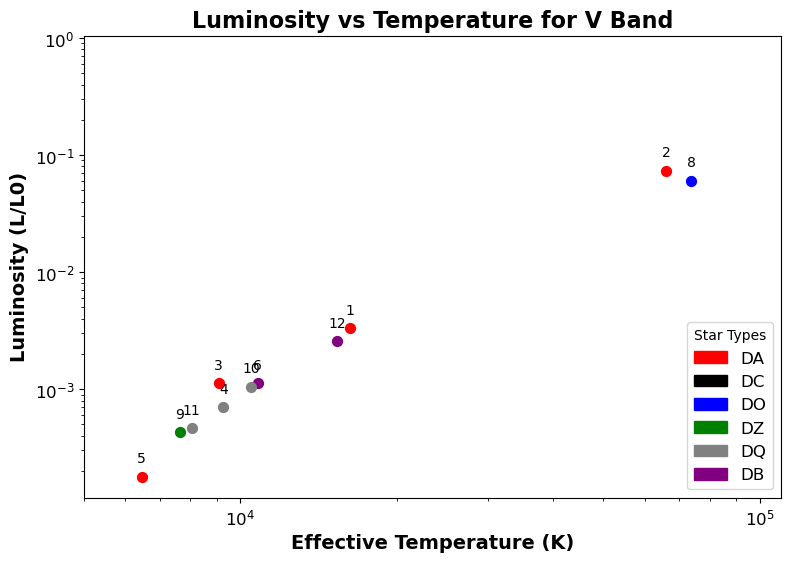

In [118]:
# Plot the values from the literature. Luminosities come from V band magnitudes. Note there is no temperature data for star 7 so it is not shown.

plt.figure(figsize=(9, 6))
plt.xlim(5e3, 1.1e5)

for i, name in enumerate(star_names):
    plt.scatter(literature_temperatures[i], literature_luminosities[i]/solar_luminosity, color=color_map[star_types[i]], label=f'{i+1}: {name}', s=50)
    plt.annotate(i+1, (literature_temperatures[i], literature_luminosities[i]/solar_luminosity), textcoords="offset points", xytext=(0,10), ha='center')

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=star_type) for star_type, color in color_map.items()]
plt.legend(handles=legend_handles, title="Star Types", fontsize=12, loc='lower right')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Effective Temperature (K)', fontweight='bold', fontsize=14)
plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
plt.title('Luminosity vs Temperature for V Band', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('Images/Literature_White_Dwarf_Luminosity_vs_Temp.png')
plt.show()